<a href="https://colab.research.google.com/github/blipbloping/Anomaly-Detection/blob/main/crps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [12]:
import pandas as pd

# Load the exported CSV
training_data1 = pd.read_csv("week1_day1.csv", encoding='latin1')
testing_data1 = pd.read_csv("week5_day1.csv", encoding='latin1')
tcp_data = training_data1[training_data1['Protocol'].str.upper() == 'TCP']
tcp_test = testing_data1[testing_data1['Protocol'].str.upper() == 'TCP']
# Display the first few rows
print(tcp_data.head())

    No.       Time          Source     Destination Protocol  Length  \
47   48  37.290142   196.37.75.158  172.16.113.105      TCP      60   
48   49  37.294817  172.16.113.105   196.37.75.158      TCP      60   
49   50  37.295017   196.37.75.158  172.16.113.105      TCP      60   
50   51  37.295563   196.37.75.158  172.16.113.105      TCP      60   
51   52  37.307251  172.16.113.105   196.37.75.158      TCP      60   

                                                 Info  
47     1024  >  79 [SYN] Seq=0 Win=512 Len=0 MSS=1460  
48  79  >  1024 [SYN, ACK] Seq=0 Ack=1 Win=32736 L...  
49      1024  >  79 [ACK] Seq=1 Ack=1 Win=32120 Len=0  
50  1024  >  79 [PSH, ACK] Seq=1 Ack=1 Win=32120 L...  
51      79  >  1024 [ACK] Seq=1 Ack=5 Win=32732 Len=0  


In [18]:
time_window = 75.0 # 1 second time window
tcp_data['Time_Window'] = (tcp_data['Time'] // time_window).astype(int)
packet_count = tcp_data.groupby("Time_Window").size()
tcp_data["Inter_Arrival_Time"] = tcp_data["Time"].diff()
iat_avg = tcp_data.groupby("Time_Window")["Inter_Arrival_Time"].mean()

# Combine Results
result = pd.DataFrame({
    "Packet_Count": packet_count,
    "Avg_Inter_Arrival_Time": iat_avg
}).fillna(0)

#print(tcp_data.head())
print(result.head())

             Packet_Count  Avg_Inter_Arrival_Time
Time_Window                                      
0                     299                8.348772
1                      92                1.311864
2                      33                0.961525
3                      65                0.621235
4                      17                0.429880


<ipython-input-18-0b2de6583c74>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcp_data['Time_Window'] = (tcp_data['Time'] // time_window).astype(int)
<ipython-input-18-0b2de6583c74>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcp_data["Inter_Arrival_Time"] = tcp_data["Time"].diff()


In [19]:
time_window = 75.0 # 1 second time window
tcp_test['Time_Window'] = (tcp_test['Time'] // time_window).astype(int)
packet_count1 = tcp_test.groupby("Time_Window").size()
tcp_test["Inter_Arrival_Time"] = tcp_test["Time"].diff()
iat_avg1 = tcp_test.groupby("Time_Window")["Inter_Arrival_Time"].mean()

# Combine Results
result1 = pd.DataFrame({
    "Packet_Count": packet_count1,
    "Avg_Inter_Arrival_Time": iat_avg1
}).fillna(0)

#print(tcp_data.head())
print(result1.head())

             Packet_Count  Avg_Inter_Arrival_Time
Time_Window                                      
2                       8               24.357061


<ipython-input-19-9fc5f6bc909d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcp_test['Time_Window'] = (tcp_test['Time'] // time_window).astype(int)
<ipython-input-19-9fc5f6bc909d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcp_test["Inter_Arrival_Time"] = tcp_test["Time"].diff()


In [20]:
def apply_pca(features):
    pca = PCA(n_components=1)
    pca_features = pca.fit_transform(features)
    return pca_features, pca
train_pca, pca_model = apply_pca(result)
print(train_pca.shape)
print(pca_model)

(777, 1)
PCA(n_components=1)


In [31]:
def compute_crps(observed, cdf):
    return np.mean((cdf - (observed <= cdf)) ** 2)
def compute_threshold(crps_values, alpha=0.99):
    kde = KernelDensity(kernel='gaussian').fit(crps_values)
    threshold = np.percentile(crps_values, alpha * 100)
    return kde, threshold
kde_model, crps_threshold = compute_threshold(train_pca)

In [32]:
print(crps_threshold)

2163.4727318119753


In [23]:
def detect_anomalies(test_data, kde, threshold, pca):
    # Transform test data using PCA
    test_pca = pca.transform(test_data)
    crps_test = compute_crps(test_pca, norm.cdf(test_pca))
    print(threshold)
    print(crps_test)
    anomalies = crps_test > threshold
    return anomalies
anomalies = detect_anomalies(result1, kde_model, crps_threshold, pca_model)
print(anomalies)

2163.4727318119753
1.0
False


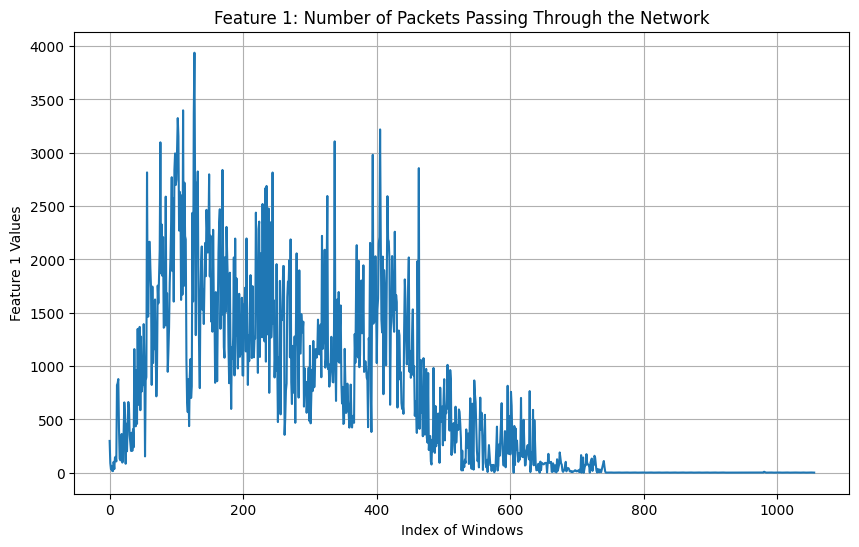

In [26]:
feature1 = packet_count
feature2 = 1/iat_avg
plt.figure(figsize=(10, 6))
plt.plot(feature1)
plt.title('Feature 1: Number of Packets Passing Through the Network')
plt.xlabel('Index of Windows')
plt.ylabel('Feature 1 Values')
plt.grid()
plt.show()

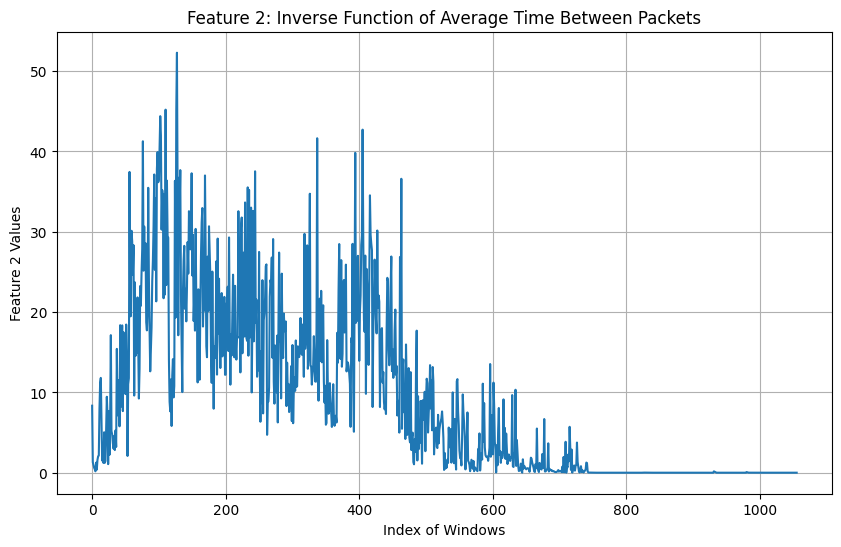

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(feature2)
plt.title('Feature 2: Inverse Function of Average Time Between Packets')
plt.xlabel('Index of Windows')
plt.ylabel('Feature 2 Values')
plt.grid()
plt.show()

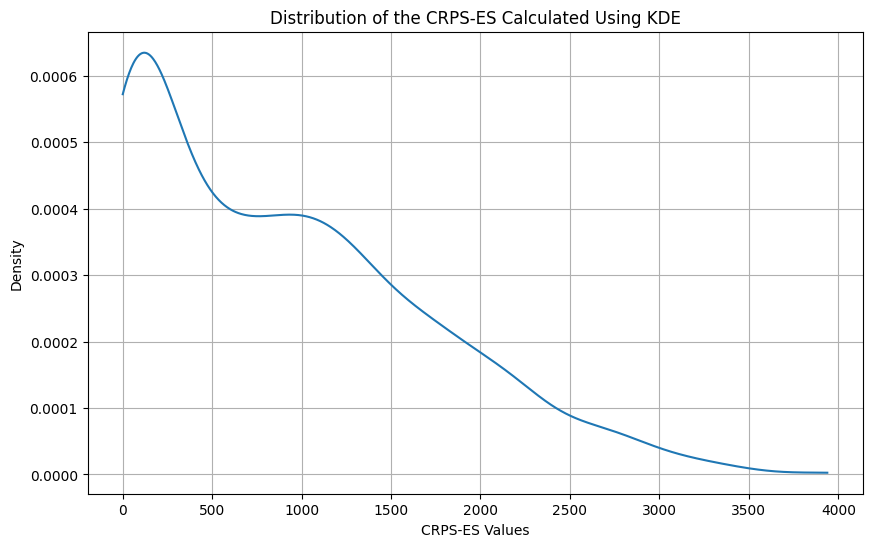

In [33]:
kde = gaussian_kde(packet_count)
x_vals = np.linspace(packet_count.min(), packet_count.max(), 1000)
kde_vals = kde(x_vals)
plt.figure(figsize=(10, 6))
plt.plot(x_vals, kde_vals)
plt.title('Distribution of the CRPS-ES Calculated Using KDE')
plt.xlabel('CRPS-ES Values')
plt.ylabel('Density')
plt.grid()
plt.show()